In [29]:
import networkx as nx
import osmnx as ox
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
from collections import Counter
import yaml
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [54]:
class graphGenerator:
    # TODO: add edge capacities
        # shortest path where capacity > 0
        # when allocating path, capacity - 1 for all edges in path
    # TODO: remove speed
        # dictionary mapping general: speed for edges
        # ? dictionary mapping general: capacity for edges
        # dictionary mapping genera: color for edges and nodes
    # ? can add agents to edges when moving
    def __init__(self, lat: float, lon: float, radius: int, tolerance: int, 
                 building_filepath: str, highway_filepath: str, osm_filepath: str) -> None:
        self.coords = (float(lat), float(lon))
        self.radius = int(radius)
        self.tolerance = int(tolerance)
        self.building_filepath = str(building_filepath)
        self.highway_filepath = str(highway_filepath)
        self.osm_filepath = str(osm_filepath)
        
        self.G = self.download_network()
        self.nodes, self.edges = self.get_nodes_edges_from_graph()
        
        all_nodes = self.add_buildings()
        self.simplify_network()
        self.nodes, self.edges = self.get_nodes_edges_from_graph()
        
        self.set_building_type(all_nodes)
        self.add_node_edge_attrs()
        
        self.clean_graph_attrs()
        self.save_graph2osm()
        
        self.check_osm()
    
    def download_network(self):
        return ox.graph_from_point(self.coords, 
                                dist=self.radius,
                                network_type="all",
                                retain_all=True,
                                simplify=False
                                )
    
    def get_nodes_edges_from_graph(self):
        return ox.graph_to_gdfs(self.G, nodes=True, edges=True)
    
    def plot_graph(self):
        G_inter = ox.graph_from_gdfs(self.nodes, self.edges)
        G_inter = ox.project_graph(self.G)
        fig, ax = ox.plot_graph(G_inter, node_size=10)
    
    def add_buildings(self):
        tags = {"building": True} 
        buildings = ox.features_from_point(self.coords, tags, 
                                           dist=self.radius)

        centroids = buildings.centroid
        building_list = []
        edge_list = []
        
        # iterate over buildings
        for i, c in enumerate(centroids):
            # create node list
            building_list.append({'geometry': Point(c.x, c.y),
                                'osmid': i+1,
                                'y': c.y,
                                'x': c.x,
                                'building': buildings.iloc[i]['building'],
                                })
            # find closest preexisiting node in G
            proxy_node_id, dist = ox.distance.nearest_nodes(self.G, c.x, c.y, return_dist=True)
            proxy_node = self.nodes.loc[proxy_node_id]
            
            # create edge list of building node to proxy node
            edge_list.append({'geometry': LineString([(c.x, c.y), (proxy_node.x, proxy_node.y)]),
                            'osmid': 2000000+i+1,                  # TODO: find max value to make adaptable
                            'highway': 'residential',
                            'oneway': False,
                            'length': dist,
                            'lanes': 1,
                            'u': i+1,
                            'v': proxy_node_id,
                            'key': 0,
                            })
        
        # Turn into dfs and set compatible idxs
        my_nodes = gpd.GeoDataFrame(building_list)
        my_nodes.set_index('osmid', inplace=True)

        my_edges = gpd.GeoDataFrame(edge_list)
        my_edges.set_index(['u', 'v', 'key'], inplace=True)

        # transform street_count to building, drop highway
        self.nodes['building'] = 'street'
        if 'highway' in self.nodes.columns:
            self.nodes = self.nodes.drop(['street_count', 'highway'], axis=1)

        # Combine building and intersection nodes; Combine edges
        all_nodes = pd.concat([self.nodes, my_nodes])
        all_edges = pd.concat([self.edges, my_edges])

        # Simplify edges and nodes
        all_nodes = all_nodes[['building', 'x', 'y', 'geometry']]
        all_edges = all_edges[['osmid', 'highway', 'length', 'geometry']]
        
        # Make graph
        self.G = ox.graph_from_gdfs(all_nodes, all_edges)
        return all_nodes
            
    def simplify_network(self):
        # collapse nodes within tolerance
        G_temp = ox.project_graph(self.G)
        G_temp = ox.consolidate_intersections(G_temp, rebuild_graph=True, reconnect_edges=True, 
                                            dead_ends=True, tolerance=self.tolerance)
        # remove islands
        self.G = ox.utils_graph.get_largest_component(G_temp)
    
    def set_building_type(self, all_nodes):
        # set building type according to majority vote
        for i, r in self.nodes.iterrows():
            if type(r['osmid_original']) == str:
                osmid_list = [int(i) for i in r['osmid_original'][1:-1].split(", ")]

                counts = {}
                for n in osmid_list:
                    build_type = all_nodes.loc[n, 'building']
                    if build_type in counts:
                        counts[build_type] = counts[build_type] + 1
                    else:
                        counts[build_type] = 1
                
                if len(counts.keys()) == 1 and 'yes' in counts:
                    print('yes only node type in cluster')
                    self.nodes.loc[i, 'building'] = 'street'
                else:
                    if 'yes' in counts.keys():  
                        del counts['yes']
                    maj_vote = max(counts.items(), key=lambda x: x[1])[0]
                    self.nodes.loc[i, 'building'] = maj_vote
    
    def read_yaml(self):
        # read building and highway OSM saved as yaml
        with open(self.building_filepath, 'r') as f:
            building_yaml = yaml.safe_load(f)

        with open(self.highway_filepath, 'r') as f:
            highway_yaml = yaml.safe_load(f)
        
        return building_yaml, highway_yaml

    def add_node_edge_attrs(self):
        building_yaml, highway_yaml = self.read_yaml()
        
        # Add node building attributes
        for i, r in self.nodes.iterrows():
            building = self.nodes.loc[i, 'building']
            
            if building in building_yaml.keys():
                general, color = building_yaml[building]['general'], building_yaml[building]['color']
            else:
                general, color = 'street', 'gray'
            self.nodes.loc[i, 'general'] = general
            self.nodes.loc[i, 'color'] = color

        # Add edge street attributes
        for i, r in self.edges.iterrows():
            highway = self.edges.loc[i, 'highway']
            if highway in highway_yaml.keys():
                general = highway_yaml[highway]['general']
                color = highway_yaml[highway]['color']
                speed = highway_yaml[highway]['speed']
            else:
                general, color, speed = highway, 'gray', 16100
            self.edges.loc[i, 'general'] = general
            self.edges.loc[i, 'color'] = color
            self.edges.loc[i, 'speed'] = speed
    
    def clean_graph_attrs(self):
        # Simplify edges and nodes
        self.nodes = self.nodes[['building', 'general', 'color', 
                                 'x', 'y', 'geometry']]
        self.edges = self.edges[['osmid', 'highway', 'general', 'color', 
                                 'length', 'speed', 'geometry']]

        # Make graph
        self.G = ox.graph_from_gdfs(self.nodes, self.edges)
        
    def save_graph2osm(self):
        ox.save_graphml(self.G, filepath=self.osm_filepath)
        
    def check_osm(self):
        G_star = ox.load_graphml(self.osm_filepath,
                                 node_dtypes={'building':str, 'general':str, 'color':str, 
                                              'x':float, 'y':float, 'geometry':str},
                                 edge_dtypes={'osmid':int, 'highway':str, 'general':str, 
                                              'color':str, 'length':float, 'speed':float, 'geometry':str})
        # make geographically accurate layout
        layout = { n[0] : [ n[1]['x'], n[1]['y'] ] for n in G_star.nodes(data=True) }

        # Make Undirected
        uG_star = G_star.to_undirected()
        
        # draw save
        nodes, edges = uG_star.nodes(data=True), uG_star.edges(data=True)
        print(f"{len(nodes)} nodes and {len(edges)} edges")
        
        node_color = [ v['color'] for (k, v) in nodes ]
        edge_color = [ d['color'] for (u, v, d) in edges ]
        max_road_len = max([ d['length'] for (u, v, d) in edges ])
        edge_weight = [ d['length'] / max_road_len for (u, v, d) in edges ]
        print(Counter(node_color))
        
        nx.draw_networkx(uG_star, pos=layout,
                        edge_color=edge_color, 
                        node_color=node_color,
                        width=edge_weight,
                        node_size=5,     # edge_cmap
                        with_labels=False)

/var/folders/9c/5hbdnj_57xv861zqcz43bs6w0000gn/T/ipykernel_81771/944945790.py:47: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = buildings.centroid
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/osmnx/simplification.py:533: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of panda

1148 nodes and 1445 edges
Counter({'gray': 1112, 'orange': 21, 'blue': 13, 'purple': 2})


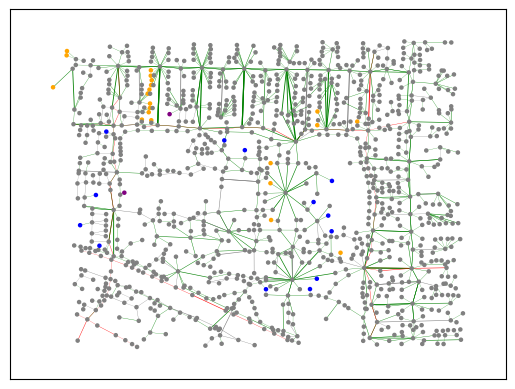

In [31]:
lily = graphGenerator(36.00780585133558, -78.91533560763814,
                      500, 5, "yaml/building.yaml", "yaml/highway.yaml", "osm_data/east.osm")

/var/folders/9c/5hbdnj_57xv861zqcz43bs6w0000gn/T/ipykernel_81771/944945790.py:47: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = buildings.centroid
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/osmnx/simplification.py:533: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of panda

3018 nodes and 3235 edges
Counter({'orange': 1737, 'gray': 1111, 'blue': 164, 'purple': 6})


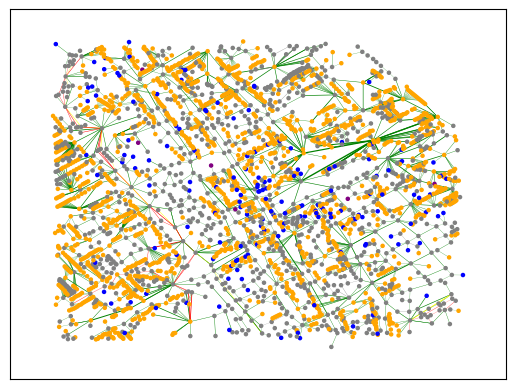

In [33]:
delft = graphGenerator(52.01178565859011, 4.357517442803557,
                      500, 5, "building.yaml", "highway.yaml", "osm_data/delft.osm")

/var/folders/9c/5hbdnj_57xv861zqcz43bs6w0000gn/T/ipykernel_81771/944945790.py:47: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = buildings.centroid
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/osmnx/simplification.py:533: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of panda

925 nodes and 1193 edges
Counter({'gray': 861, 'orange': 36, 'blue': 28})


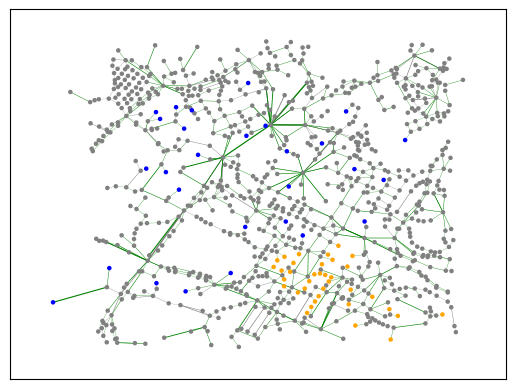

In [34]:
chapel = graphGenerator(36.0020652458254, -78.94031664520642,
                      500, 5, "building.yaml", "highway.yaml", "osm_data/west.osm")

/var/folders/9c/5hbdnj_57xv861zqcz43bs6w0000gn/T/ipykernel_81771/944945790.py:47: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = buildings.centroid
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/osmnx/simplification.py:533: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of panda

1392 nodes and 1492 edges
Counter({'gray': 1093, 'orange': 277, 'blue': 20, 'purple': 2})


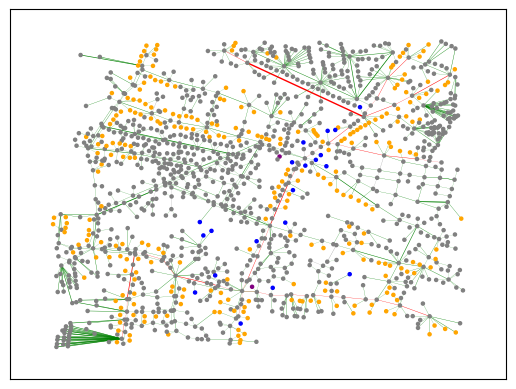

In [36]:
vienna = graphGenerator(48.15354942278057, 16.26938663007299,
                      500, 5, "building.yaml", "highway.yaml", "osm_data/vienna.osm")

/var/folders/9c/5hbdnj_57xv861zqcz43bs6w0000gn/T/ipykernel_81771/944945790.py:47: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = buildings.centroid
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/osmnx/simplification.py:533: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of panda

1321 nodes and 1563 edges
Counter({'gray': 1008, 'orange': 292, 'blue': 15, 'purple': 6})


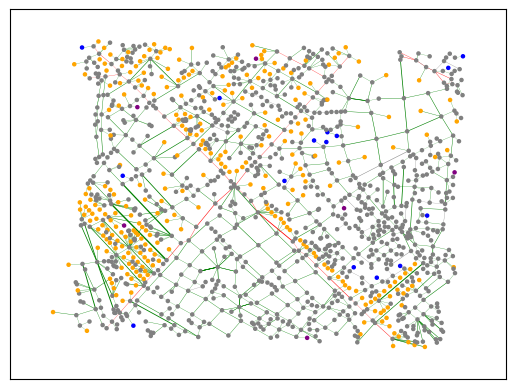

In [37]:
copenhagen = graphGenerator(55.69405607979743, 12.55028245734521,
                      500, 5, "building.yaml", "highway.yaml", "osm_data/copenhagen.osm")

/var/folders/9c/5hbdnj_57xv861zqcz43bs6w0000gn/T/ipykernel_81771/944945790.py:47: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = buildings.centroid
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/osmnx/simplification.py:533: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of panda

1916 nodes and 2221 edges
Counter({'gray': 1860, 'blue': 34, 'orange': 12, 'purple': 10})


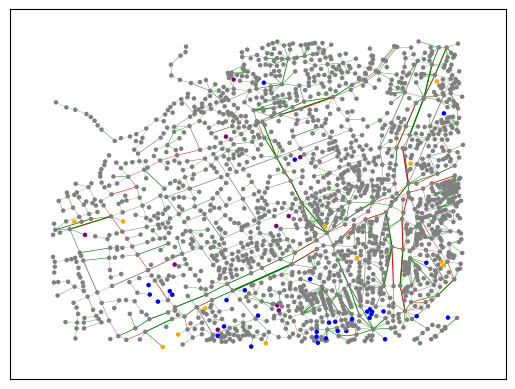

In [38]:
kobe = graphGenerator(34.698375822779816, 135.1900687171518,
                      500, 5, "building.yaml", "highway.yaml", "osm_data/kobe.osm")

/var/folders/9c/5hbdnj_57xv861zqcz43bs6w0000gn/T/ipykernel_81771/944945790.py:47: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = buildings.centroid
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/osmnx/simplification.py:533: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of panda

1441 nodes and 2020 edges
Counter({'gray': 1295, 'blue': 122, 'orange': 23, 'purple': 1})


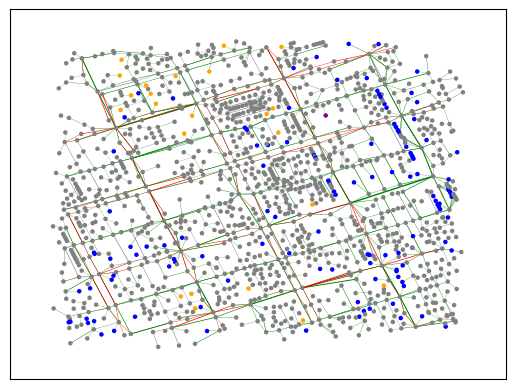

In [39]:
melbourne = graphGenerator(-37.813792666556104, 144.96045493178508,
                      500, 5, "building.yaml", "highway.yaml", "osm_data/melbourne.osm")

/var/folders/9c/5hbdnj_57xv861zqcz43bs6w0000gn/T/ipykernel_81771/944945790.py:47: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = buildings.centroid
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/osmnx/simplification.py:533: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of panda

1887 nodes and 2230 edges
Counter({'orange': 960, 'gray': 925, 'purple': 1, 'blue': 1})


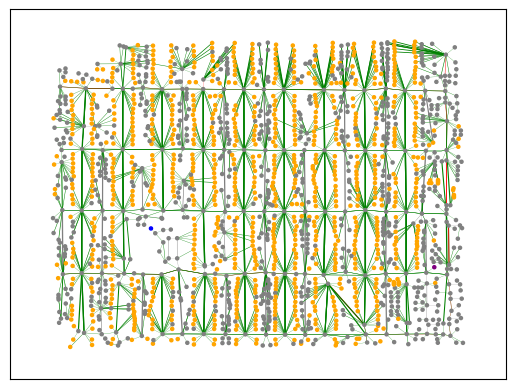

In [40]:
seattle = graphGenerator(47.567148905364725, -122.39296662731103,
                      500, 5, "building.yaml", "highway.yaml", "osm_data/seattle.osm")

/var/folders/9c/5hbdnj_57xv861zqcz43bs6w0000gn/T/ipykernel_81771/944945790.py:47: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = buildings.centroid
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/osmnx/simplification.py:533: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of panda

966 nodes and 1364 edges
Counter({'gray': 881, 'orange': 49, 'blue': 35, 'purple': 1})


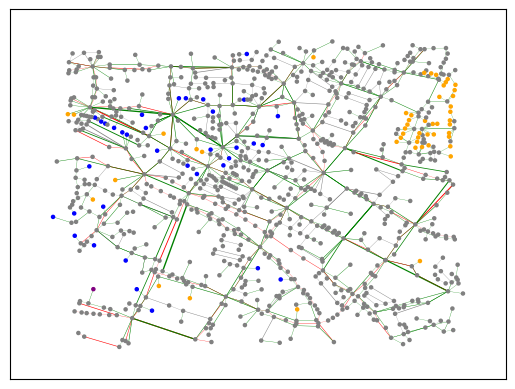

In [41]:
durham = graphGenerator(35.99413950843238, -78.89914609768432,
                      500, 5, "building.yaml", "highway.yaml", "osm_data/durham.osm")

/var/folders/9c/5hbdnj_57xv861zqcz43bs6w0000gn/T/ipykernel_81771/944945790.py:47: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = buildings.centroid
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/osmnx/simplification.py:533: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of panda

983 nodes and 1146 edges
Counter({'gray': 927, 'orange': 27, 'blue': 21, 'purple': 8})


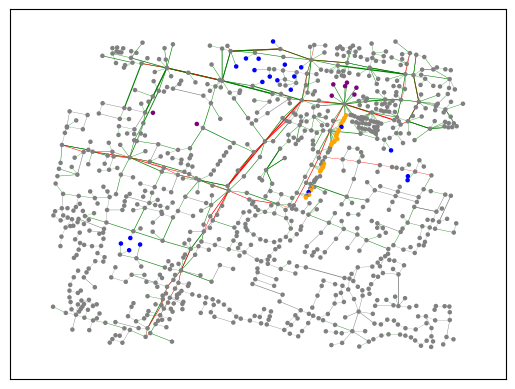

In [42]:
hanoi = graphGenerator(21.0275416015008, 105.83490293582753,
                      500, 5, "building.yaml", "highway.yaml", "osm_data/hanoi.osm")

/var/folders/9c/5hbdnj_57xv861zqcz43bs6w0000gn/T/ipykernel_81771/944945790.py:47: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = buildings.centroid
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/osmnx/simplification.py:533: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of panda

765 nodes and 1028 edges
Counter({'gray': 564, 'orange': 159, 'blue': 42})


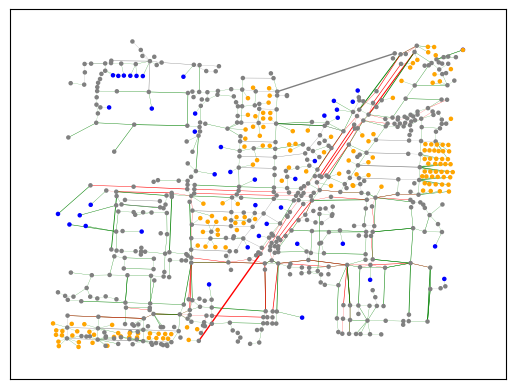

In [44]:
taipei = graphGenerator(25.041160677715496, 121.5631458360065,
                      500, 5, "building.yaml", "highway.yaml", "osm_data/taipei.osm")

/var/folders/9c/5hbdnj_57xv861zqcz43bs6w0000gn/T/ipykernel_81771/3720056978.py:47: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = buildings.centroid


Index(['y', 'x', 'highway', 'street_count', 'ref', 'geometry', 'building'], dtype='object')


/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/osmnx/simplification.py:533: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '148-0' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  gdf.loc[idx, "cluster"] = f"{cluster_label}-{suffix}"
/var/folders/9c/5hbdnj_57xv861zqcz43bs6w0000gn/T/ipykernel_81771/3720056978.py:153: FutureWarning: Setting an item of incompatible dtype is 

539 nodes and 642 edges
Counter({'gray': 412, 'orange': 101, 'blue': 26})


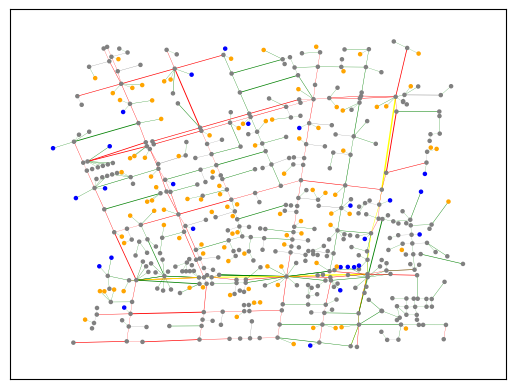

In [53]:
tehran = graphGenerator(35.70355000944654, 51.40194989842805,
                      500, 5, "building.yaml", "highway.yaml", "osm_data/tehran.osm")

/var/folders/9c/5hbdnj_57xv861zqcz43bs6w0000gn/T/ipykernel_81771/1792990488.py:47: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = buildings.centroid
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/osmnx/simplification.py:533: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pand

1052 nodes and 1119 edges
Counter({'gray': 1024, 'orange': 15, 'blue': 11, 'purple': 2})


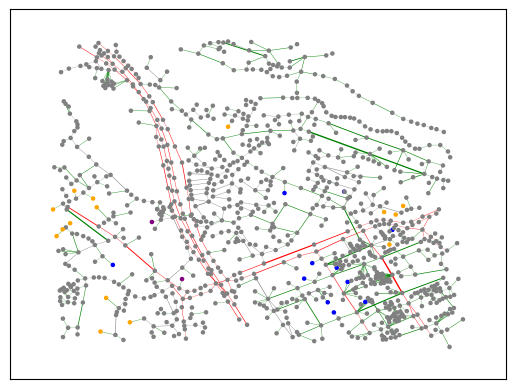

In [58]:
nairobi = graphGenerator(-1.2789765538765308, 36.8158145145407,
                      500, 5, "building.yaml", "highway.yaml", "osm_data/nairobi.osm")

/var/folders/9c/5hbdnj_57xv861zqcz43bs6w0000gn/T/ipykernel_81771/1792990488.py:47: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = buildings.centroid
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/osmnx/simplification.py:533: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pand

364 nodes and 448 edges
Counter({'gray': 330, 'orange': 29, 'blue': 5})


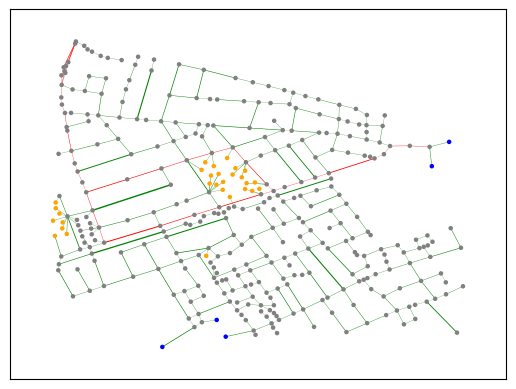

In [65]:
tunis = graphGenerator(36.809973465136146, 10.111482636948368,
                      500, 5, "building.yaml", "highway.yaml", "osm_data/tunis.osm")

/var/folders/9c/5hbdnj_57xv861zqcz43bs6w0000gn/T/ipykernel_81771/1792990488.py:47: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = buildings.centroid
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/osmnx/simplification.py:533: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pand

903 nodes and 1166 edges
Counter({'gray': 866, 'blue': 29, 'orange': 6, 'purple': 2})


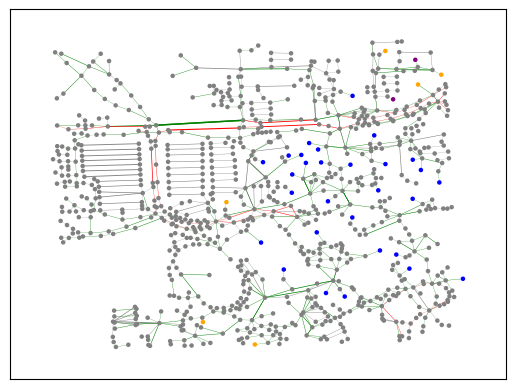

In [66]:
calgary = graphGenerator(51.07940052969779, -114.13387524962569,
                      500, 5, "building.yaml", "highway.yaml", "osm_data/calgary.osm")

/var/folders/9c/5hbdnj_57xv861zqcz43bs6w0000gn/T/ipykernel_81771/1792990488.py:47: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = buildings.centroid
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/osmnx/simplification.py:533: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pand

404 nodes and 487 edges
Counter({'gray': 397, 'orange': 5, 'blue': 2})


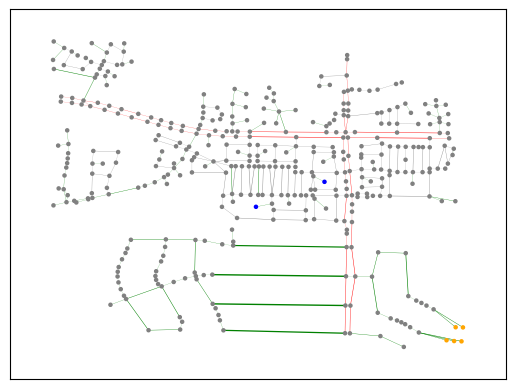

In [69]:
bradenton = graphGenerator(27.44435045082357, -82.50772245728717,
                      500, 5, "building.yaml", "highway.yaml", "osm_data/bradenton.osm")

/var/folders/9c/5hbdnj_57xv861zqcz43bs6w0000gn/T/ipykernel_81771/1792990488.py:47: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = buildings.centroid
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/osmnx/simplification.py:533: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pand

1338 nodes and 1459 edges
Counter({'gray': 1132, 'orange': 200, 'blue': 6})


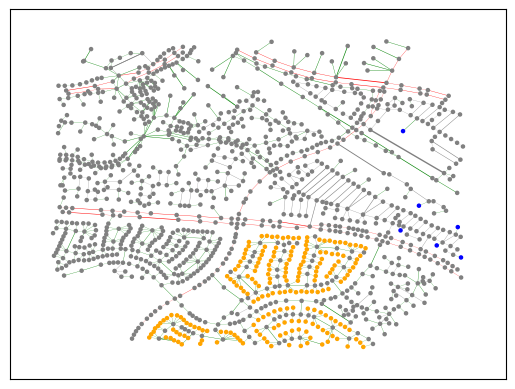

In [70]:
la = graphGenerator(33.68341935726835, -117.81710560554986,
                      500, 5, "building.yaml", "highway.yaml", "osm_data/la.osm")